# 개선된 콜레스테롤 예측 모델
## Random Forest, XGBoost, 성능 비교 및 교차 검증

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, confusion_matrix, accuracy_score
)
from xgboost import XGBRegressor, XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [2]:
# 데이터 로드 및 전처리
df = pd.read_csv('./data/health_2023_cleaned_final.csv')

# 파생 변수 생성
df['BMI'] = (df['체중(5kg단위)'] * 1.0) / ((df['신장(5cm단위)'] / 100) ** 2)
df['허리신장비'] = df['허리둘레'] / df['신장(5cm단위)']
df['BMI_범주'] = pd.cut(df['BMI'], bins=[0, 18.5, 23, 25, 30, 100], 
                      labels=['저체중', '정상', '과체중', '경도비만', '중등도이상비만'])

# 연령대 그룹화
df['연령대_그룹'] = pd.cut(df['연령대코드(5세단위)'], bins=[0, 6, 10, 14, 20], 
                       labels=['청년', '중년', '장년', '노년'])

print(f"데이터 크기: {df.shape}")
print(f"파생 변수 생성 완료")

데이터 크기: (332704, 34)
파생 변수 생성 완료


## 1. 회귀 모델 - 콜레스테롤 수치 예측

In [3]:
# 회귀 모델용 데이터 준비
feature_columns = [
    '연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '흡연상태', '음주여부', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
    'HDL콜레스테롤', '트리글리세라이드', 'BMI', '허리신장비'
]

target_column = '총콜레스테롤'

# 결측치 제거
regression_data = df[feature_columns + [target_column]].dropna()
print(f"전체 데이터 크기: {regression_data.shape}")

# 성능 최적화를 위한 샘플링 (50,000개로 제한)
if len(regression_data) > 50000:
    regression_data = regression_data.sample(n=50000, random_state=42)
    print(f"샘플링된 데이터 크기: {regression_data.shape}")

X_reg = regression_data[feature_columns]
y_reg = regression_data[target_column]

# 데이터 분할
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# 정규화
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

print(f"훈련 데이터: {X_train_reg.shape}, 테스트 데이터: {X_test_reg.shape}")

전체 데이터 크기: (332651, 15)
샘플링된 데이터 크기: (50000, 15)
훈련 데이터: (40000, 14), 테스트 데이터: (10000, 14)


In [4]:
# 다양한 회귀 모델 훈련 및 평가 (성능 최적화)
regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(
        n_estimators=50,  # 100 -> 50으로 줄임
        max_depth=20,     # 깊이 제한
        min_samples_split=10,  # 분할 조건 강화
        n_jobs=-1,        # 멀티프로세싱
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=50,  # 100 -> 50으로 줄임
        max_depth=6,      # 깊이 제한
        learning_rate=0.1,
        n_jobs=-1,        # 멀티프로세싱
        random_state=42
    )
}

regression_results = {}

for name, model in regression_models.items():
    print(f"\n=== {name} 모델 훈련 중... ===")
    
    # 모델 훈련
    if name == 'Linear Regression':
        model.fit(X_train_reg_scaled, y_train_reg)
        y_pred = model.predict(X_test_reg_scaled)
    else:
        model.fit(X_train_reg, y_train_reg)
        y_pred = model.predict(X_test_reg)
    
    # 성능 평가
    mae = mean_absolute_error(y_test_reg, y_pred)
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_reg, y_pred)
    
    # 교차 검증 (3-fold로 줄여서 속도 향상)
    print("교차 검증 수행 중...")
    if name == 'Linear Regression':
        cv_scores = cross_val_score(model, X_train_reg_scaled, y_train_reg, 
                                   cv=3, scoring='r2', n_jobs=-1)
    else:
        cv_scores = cross_val_score(model, X_train_reg, y_train_reg, 
                                   cv=3, scoring='r2', n_jobs=-1)
    
    regression_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV_Mean_R2': cv_scores.mean(),
        'CV_Std_R2': cv_scores.std(),
        'predictions': y_pred,
        'model': model
    }
    
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"교차검증 R² (평균±표준편차): {cv_scores.mean():.3f}±{cv_scores.std():.3f}")

# 결과 요약 테이블
results_df = pd.DataFrame(regression_results).T
results_df = results_df[['MAE', 'RMSE', 'R2', 'CV_Mean_R2', 'CV_Std_R2']]
print("\n=== 회귀 모델 성능 비교 ===")
print(results_df.round(4))


=== Linear Regression 모델 훈련 중... ===
교차 검증 수행 중...
MAE: 29.139
RMSE: 36.704
R²: 0.225
교차검증 R² (평균±표준편차): 0.224±0.005

=== Random Forest 모델 훈련 중... ===
교차 검증 수행 중...
MAE: 28.674
RMSE: 36.347
R²: 0.240
교차검증 R² (평균±표준편차): 0.238±0.005

=== XGBoost 모델 훈련 중... ===
교차 검증 수행 중...
MAE: 28.190
RMSE: 35.710
R²: 0.267
교차검증 R² (평균±표준편차): 0.266±0.003

=== 회귀 모델 성능 비교 ===
                         MAE       RMSE        R2 CV_Mean_R2 CV_Std_R2
Linear Regression  29.139414  36.703992  0.225401    0.22401  0.005174
Random Forest      28.674122  36.346608  0.240412   0.238246   0.00494
XGBoost             28.19046    35.7102  0.266779   0.266033  0.002839


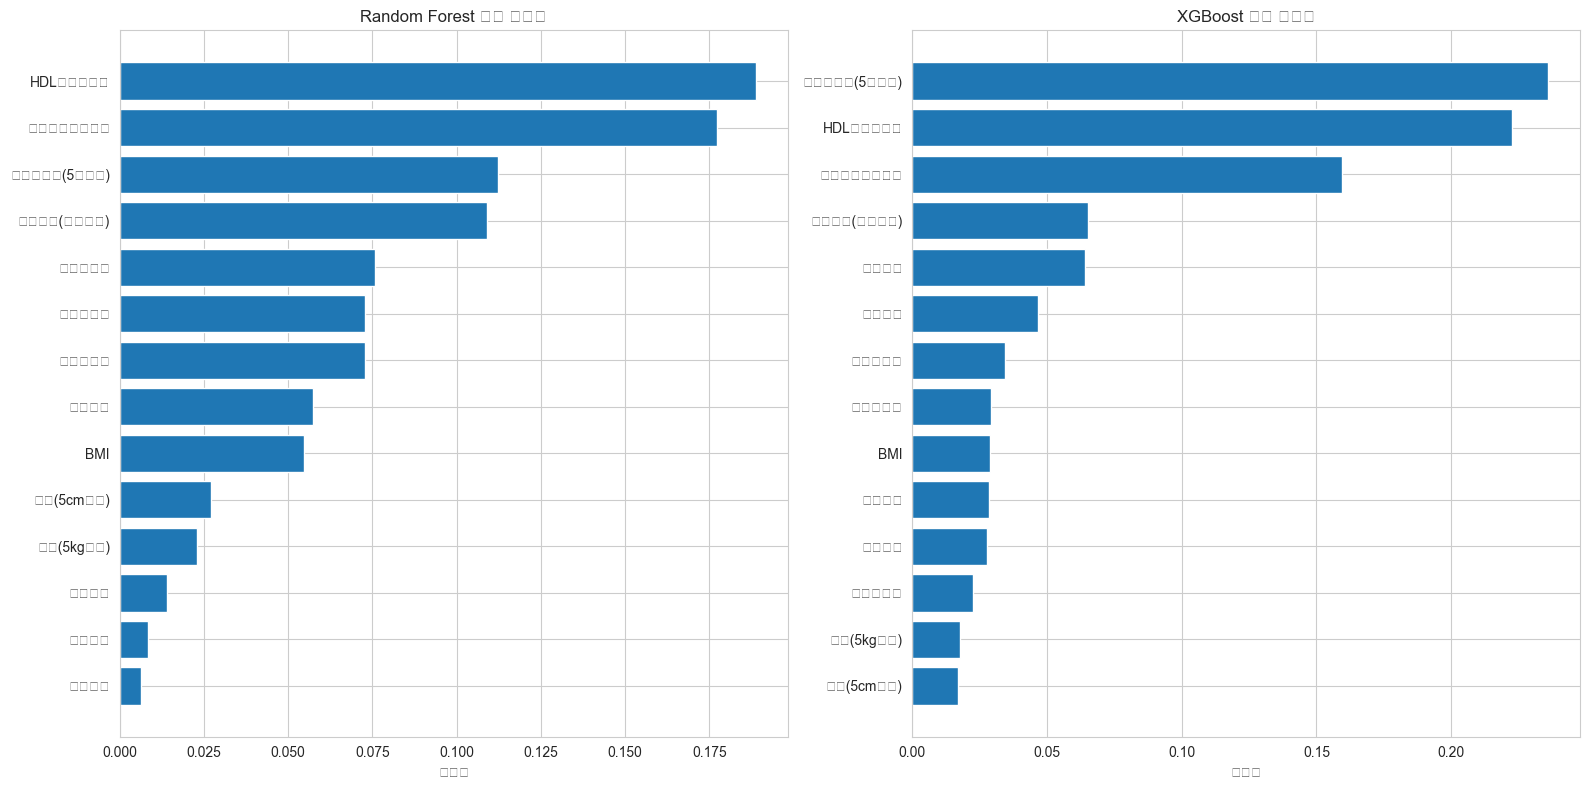


=== Random Forest 상위 5개 중요 특성 ===
        feature  importance
13        허리신장비    0.075685
9    식전혈당(공복혈당)    0.109157
0   연령대코드(5세단위)    0.112328
11     트리글리세라이드    0.177313
10     HDL콜레스테롤    0.188754

=== XGBoost 상위 5개 중요 특성 ===
        feature  importance
1          성별코드    0.064046
9    식전혈당(공복혈당)    0.065092
11     트리글리세라이드    0.159659
10     HDL콜레스테롤    0.222545
0   연령대코드(5세단위)    0.236012


In [5]:
# 특성 중요도 분석 (Random Forest와 XGBoost)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest 특성 중요도
rf_model = regression_results['Random Forest']['model']
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest 특성 중요도')
axes[0].set_xlabel('중요도')

# XGBoost 특성 중요도
xgb_model = regression_results['XGBoost']['model']
xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_title('XGBoost 특성 중요도')
axes[1].set_xlabel('중요도')

plt.tight_layout()
plt.savefig('./plots/feature_importance_regression.png', dpi=300, bbox_inches='tight')
plt.show()

# 상위 특성 출력
print("\n=== Random Forest 상위 5개 중요 특성 ===")
print(rf_importance.tail(5))
print("\n=== XGBoost 상위 5개 중요 특성 ===")
print(xgb_importance.tail(5))

## 2. 분류 모델 - 고콜레스테롤 위험군 예측

In [6]:
# 분류 모델용 데이터 준비 (고콜레스테롤 위험군 예측)
# 목표변수: 총콜레스테롤 >= 240mg/dL을 고위험군으로 분류

classification_features = [
    '연령대코드(5세단위)', '성별코드', '신장(5cm단위)', '체중(5kg단위)', '허리둘레',
    '흡연상태', '음주여부', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)',
    'HDL콜레스테롤', '트리글리세라이드', 'BMI', '허리신장비'
]

# 분류용 타겟 변수 생성
classification_data = df[classification_features + ['총콜레스테롤']].dropna()
classification_data['고콜레스테롤'] = (classification_data['총콜레스테롤'] >= 240).astype(int)

print(f"분류 분석용 데이터 크기: {classification_data.shape}")
print(f"고콜레스테롤 위험군 비율: {classification_data['고콜레스테롤'].mean():.3f}")

X_clf = classification_data[classification_features]
y_clf = classification_data['고콜레스테롤']

# 데이터 분할
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# 정규화
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

print(f"훈련 데이터: {X_train_clf.shape}, 테스트 데이터: {X_test_clf.shape}")

분류 분석용 데이터 크기: (332651, 16)
고콜레스테롤 위험군 비율: 0.147
훈련 데이터: (266120, 14), 테스트 데이터: (66531, 14)


In [7]:
# 다양한 분류 모델 훈련 및 평가
classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42)
}

classification_results = {}

for name, model in classification_models.items():
    print(f"\n=== {name} 분류 모델 훈련 중... ===")
    
    # 모델 훈련
    if name == 'Logistic Regression':
        model.fit(X_train_clf_scaled, y_train_clf)
        y_pred_clf = model.predict(X_test_clf_scaled)
        y_pred_proba = model.predict_proba(X_test_clf_scaled)[:, 1]
    else:
        model.fit(X_train_clf, y_train_clf)
        y_pred_clf = model.predict(X_test_clf)
        y_pred_proba = model.predict_proba(X_test_clf)[:, 1]
    
    # 성능 평가
    accuracy = accuracy_score(y_test_clf, y_pred_clf)
    
    # 교차 검증
    if name == 'Logistic Regression':
        cv_scores = cross_val_score(model, X_train_clf_scaled, y_train_clf, 
                                   cv=5, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X_train_clf, y_train_clf, 
                                   cv=5, scoring='accuracy')
    
    classification_results[name] = {
        'Accuracy': accuracy,
        'CV_Mean_Accuracy': cv_scores.mean(),
        'CV_Std_Accuracy': cv_scores.std(),
        'predictions': y_pred_clf,
        'probabilities': y_pred_proba,
        'model': model
    }
    
    print(f"정확도: {accuracy:.3f}")
    print(f"교차검증 정확도 (평균±표준편차): {cv_scores.mean():.3f}±{cv_scores.std():.3f}")
    print("\n분류 보고서:")
    print(classification_report(y_test_clf, y_pred_clf))

# 결과 요약 테이블
clf_results_df = pd.DataFrame(classification_results).T
clf_results_df = clf_results_df[['Accuracy', 'CV_Mean_Accuracy', 'CV_Std_Accuracy']]
print("\n=== 분류 모델 성능 비교 ===")
print(clf_results_df.round(4))


=== Logistic Regression 분류 모델 훈련 중... ===
정확도: 0.852
교차검증 정확도 (평균±표준편차): 0.852±0.000

분류 보고서:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     56739
           1       0.47      0.04      0.08      9792

    accuracy                           0.85     66531
   macro avg       0.66      0.52      0.50     66531
weighted avg       0.80      0.85      0.80     66531


=== Random Forest 분류 모델 훈련 중... ===
정확도: 0.852
교차검증 정확도 (평균±표준편차): 0.853±0.000

분류 보고서:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     56739
           1       0.47      0.04      0.07      9792

    accuracy                           0.85     66531
   macro avg       0.66      0.51      0.49     66531
weighted avg       0.80      0.85      0.79     66531


=== XGBoost 분류 모델 훈련 중... ===
정확도: 0.853
교차검증 정확도 (평균±표준편차): 0.853±0.000

분류 보고서:
              precision    recall  f1-score   support

           0       0.86 

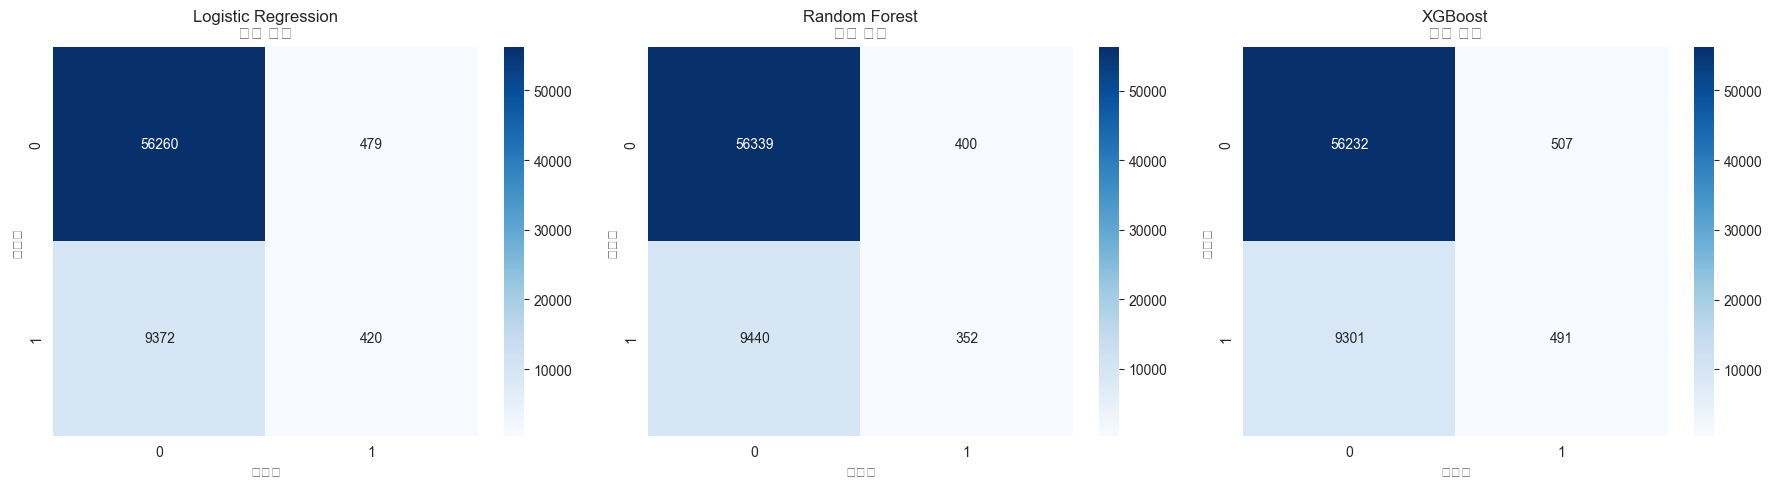

In [8]:
# 혼동 행렬 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, results) in enumerate(classification_results.items()):
    cm = confusion_matrix(y_test_clf, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}\n혼동 행렬')
    axes[idx].set_xlabel('예측값')
    axes[idx].set_ylabel('실제값')

plt.tight_layout()
plt.savefig('./plots/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. 하이퍼파라미터 최적화

In [9]:
# Random Forest 하이퍼파라미터 최적화 (회귀)
print("=== Random Forest 회귀 모델 하이퍼파라미터 최적화 ===")

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    rf_param_grid,
    cv=3,  # 시간 단축을 위해 3-fold로 설정
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train_reg, y_train_reg)

print(f"최적 파라미터: {rf_grid_search.best_params_}")
print(f"최적 교차검증 점수: {rf_grid_search.best_score_:.4f}")

# 최적화된 모델로 예측
optimized_rf = rf_grid_search.best_estimator_
y_pred_optimized = optimized_rf.predict(X_test_reg)
optimized_r2 = r2_score(y_test_reg, y_pred_optimized)
optimized_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_optimized))

print(f"최적화된 모델 성능:")
print(f"R²: {optimized_r2:.4f}")
print(f"RMSE: {optimized_rmse:.4f}")

=== Random Forest 회귀 모델 하이퍼파라미터 최적화 ===
Fitting 3 folds for each of 81 candidates, totalling 243 fits
최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
최적 교차검증 점수: 0.2570
최적화된 모델 성능:
R²: 0.2555
RMSE: 35.9847


## 4. 예측 결과 시각화

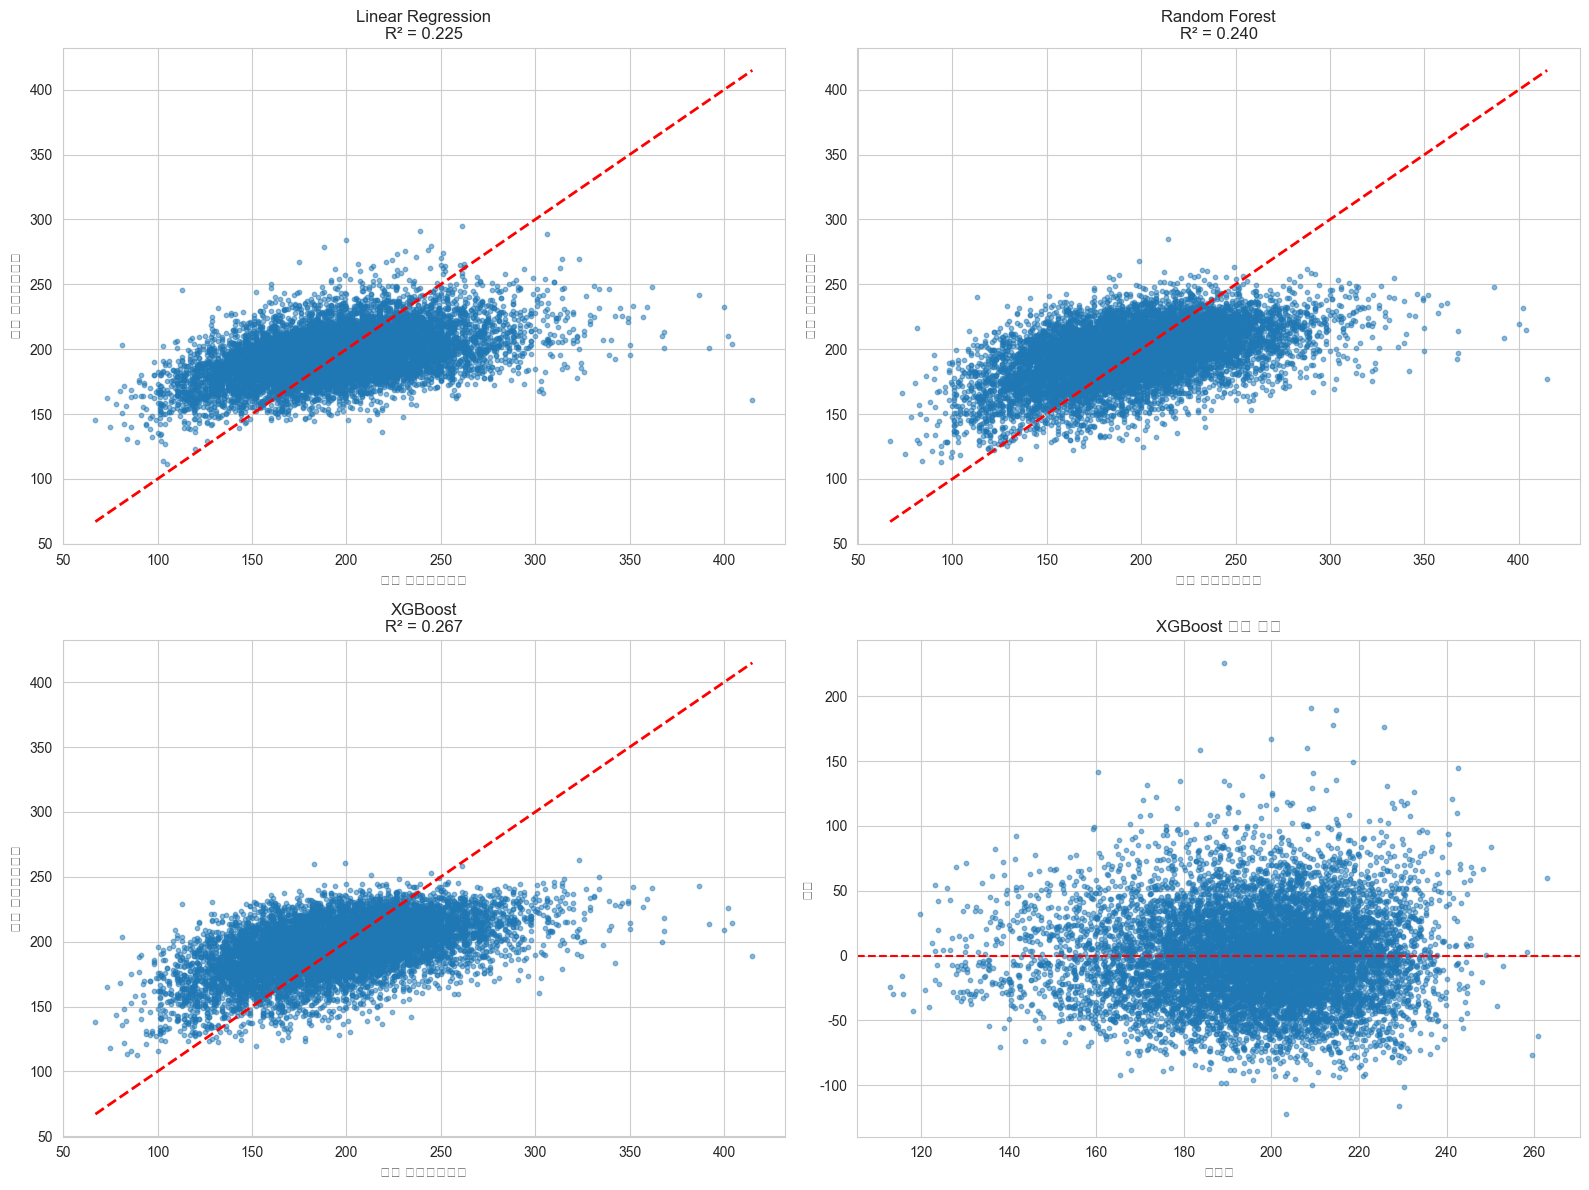

In [10]:
# 실제값 vs 예측값 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 회귀 모델 예측 결과
models_to_plot = ['Linear Regression', 'Random Forest', 'XGBoost']
for idx, model_name in enumerate(models_to_plot):
    row = idx // 2
    col = idx % 2
    
    y_pred = regression_results[model_name]['predictions']
    r2 = regression_results[model_name]['R2']
    
    axes[row, col].scatter(y_test_reg, y_pred, alpha=0.5, s=10)
    axes[row, col].plot([y_test_reg.min(), y_test_reg.max()], 
                       [y_test_reg.min(), y_test_reg.max()], 
                       'r--', lw=2)
    axes[row, col].set_xlabel('실제 총콜레스테롤')
    axes[row, col].set_ylabel('예측 총콜레스테롤')
    axes[row, col].set_title(f'{model_name}\nR² = {r2:.3f}')

# 잔차 분석 (최고 성능 모델)
best_model_name = max(regression_results.keys(), 
                     key=lambda x: regression_results[x]['R2'])
best_predictions = regression_results[best_model_name]['predictions']
residuals = y_test_reg - best_predictions

axes[1, 1].scatter(best_predictions, residuals, alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('예측값')
axes[1, 1].set_ylabel('잔차')
axes[1, 1].set_title(f'{best_model_name} 잔차 분석')

plt.tight_layout()
plt.savefig('./plots/prediction_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. 모델 성능 종합 비교

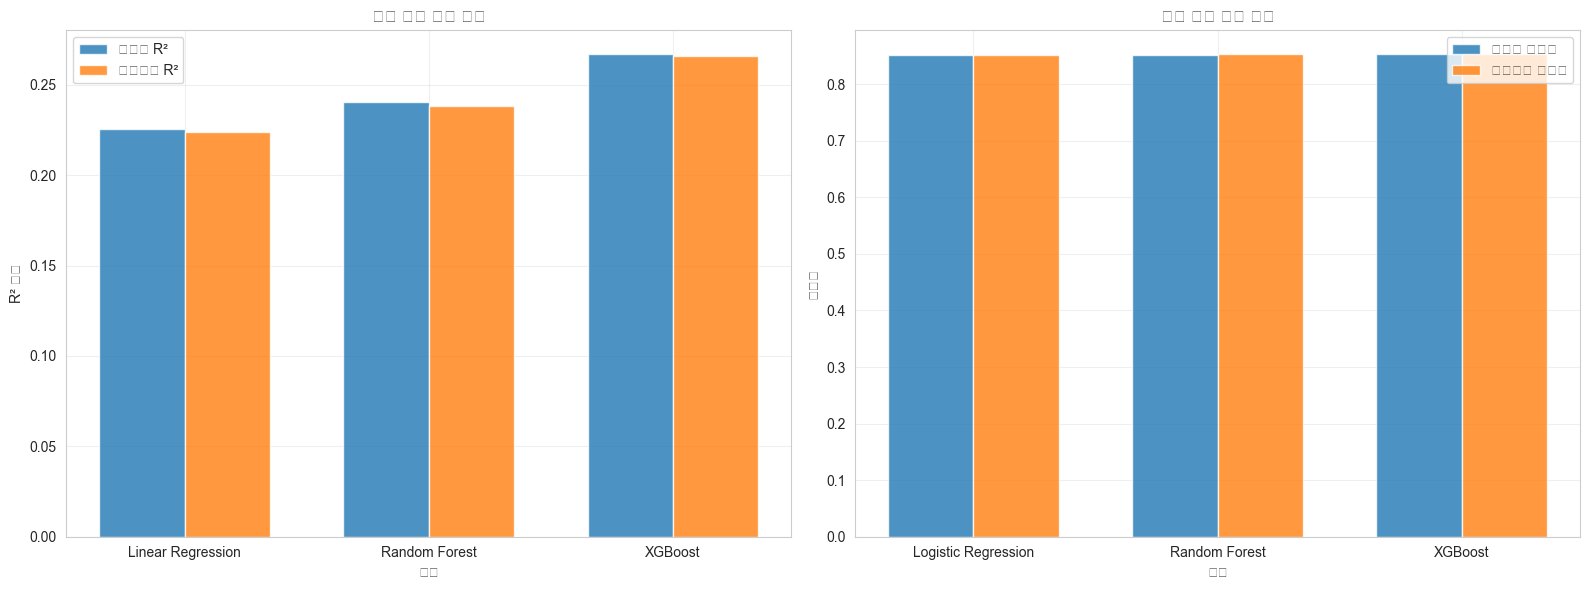


최종 모델 성능 요약

[회귀 모델 - 콜레스테롤 수치 예측]
최고 성능 모델: XGBoost
R²: 0.2668
RMSE: 35.71 mg/dL

[분류 모델 - 고콜레스테롤 위험군 예측]
최고 성능 모델: XGBoost
정확도: 0.8526



In [11]:
# 최종 성능 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 회귀 모델 R² 비교
reg_r2_scores = [regression_results[model]['R2'] for model in regression_results.keys()]
reg_cv_scores = [regression_results[model]['CV_Mean_R2'] for model in regression_results.keys()]

x = np.arange(len(regression_results))
width = 0.35

axes[0].bar(x - width/2, reg_r2_scores, width, label='테스트 R²', alpha=0.8)
axes[0].bar(x + width/2, reg_cv_scores, width, label='교차검증 R²', alpha=0.8)
axes[0].set_xlabel('모델')
axes[0].set_ylabel('R² 점수')
axes[0].set_title('회귀 모델 성능 비교')
axes[0].set_xticks(x)
axes[0].set_xticklabels(regression_results.keys())
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 분류 모델 정확도 비교
clf_acc_scores = [classification_results[model]['Accuracy'] for model in classification_results.keys()]
clf_cv_scores = [classification_results[model]['CV_Mean_Accuracy'] for model in classification_results.keys()]

x_clf = np.arange(len(classification_results))

axes[1].bar(x_clf - width/2, clf_acc_scores, width, label='테스트 정확도', alpha=0.8)
axes[1].bar(x_clf + width/2, clf_cv_scores, width, label='교차검증 정확도', alpha=0.8)
axes[1].set_xlabel('모델')
axes[1].set_ylabel('정확도')
axes[1].set_title('분류 모델 성능 비교')
axes[1].set_xticks(x_clf)
axes[1].set_xticklabels(classification_results.keys())
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 최종 결과 요약
print("\n" + "="*50)
print("최종 모델 성능 요약")
print("="*50)

print("\n[회귀 모델 - 콜레스테롤 수치 예측]")
best_reg_model = max(regression_results.keys(), 
                    key=lambda x: regression_results[x]['R2'])
print(f"최고 성능 모델: {best_reg_model}")
print(f"R²: {regression_results[best_reg_model]['R2']:.4f}")
print(f"RMSE: {regression_results[best_reg_model]['RMSE']:.2f} mg/dL")

print("\n[분류 모델 - 고콜레스테롤 위험군 예측]")
best_clf_model = max(classification_results.keys(), 
                    key=lambda x: classification_results[x]['Accuracy'])
print(f"최고 성능 모델: {best_clf_model}")
print(f"정확도: {classification_results[best_clf_model]['Accuracy']:.4f}")

print("\n" + "="*50)